In [1]:
import importlib
import mc_config #Import classes to creat configurations
import cnn_pt # Import the CNN model
import torch
import torch.nn.functional as F
import numpy as np, matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import time
import multiprocessing


In [8]:
importlib.reload(cnn_pt)

<module 'cnn_pt' from '/Users/haowuduan/Desktop/CNN_Ising_phase_transition/cnn_pt.py'>

In [2]:
num_cores=multiprocessing.cpu_count()
print("Number of cores available:", num_cores)
Beta=np.linspace(0.2, 10, 100) # Define the range of beta values
params=mc_config.Params(L=8,beta=Beta,J=1,H=0.01,N_sample=100)


Number of cores available: 10


In [3]:
# create configurations
configurations=mc_config.IsingModelDataset(params)
configurations.get_configs()
dataset=configurations.configs

In [4]:
np.save('dataset8_smallH_100.npy', dataset) # Save the dataset to a file

In [3]:
loaded_dataset = np.load('dataset8_smallH_100.npy')  # Load the dataset from the file
print("Dataset loaded with shape:",loaded_dataset.shape)

Dataset loaded with shape: (100, 100, 8, 8)


In [4]:
beta_to_index = {beta: i for i, beta in enumerate(Beta)}  # Map beta values to indices
index_to_beta = {i: beta for i, beta in enumerate(Beta)}  # Map indices back to beta values

# prepare the dataset for DataLoader
def data_preparation(dataset,Beta):
    X=torch.tensor(dataset.reshape(-1, params.L, params.L), dtype=torch.float).unsqueeze(1)
    Y=torch.tensor(np.arange(len(Beta)), dtype=torch.long).repeat_interleave(params.N_sample)
    return TensorDataset(X, Y)

# create DataLoader
batch_size=10000
data = data_preparation(loaded_dataset, Beta)
dataloader = DataLoader(data,batch_size=batch_size, shuffle=True, num_workers=num_cores)


In [5]:
# training loop 
def train_model(model,dataloader,num_epochs,learning_rate):

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    model.train()
    Losses=[]
    Accuracies=[]
    total_samples = len(dataloader.dataset)
    for epoch in range(num_epochs):
        start_time = time.time()
        epoch_loss = 0
        N_correct=0
        for batch in dataloader:
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.nll_loss(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, dim=1)
            epoch_loss += loss.item()
            N_correct += (predicted == labels).sum().item()
        Losses.append(epoch_loss / len(dataloader))
        Accuracies.append(N_correct / total_samples)
        end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}, accuracy: {N_correct/total_samples:.4f}, Time: {end_time - start_time:.2f}s')
    return Losses, Accuracies


In [6]:
model = cnn_pt.CnnPT(input_size=params.L, num_classes=len(Beta), out_channels=5, kernel_size=3, stride=2)


In [10]:
Losses, Accuracies = train_model(model, dataloader, num_epochs=1000, learning_rate=0.0001)

Epoch 1/1000, Loss: 3.0543510913848877, accuracy: 0.1923, Time: 2.47s
Epoch 2/1000, Loss: 3.05434513092041, accuracy: 0.1924, Time: 2.08s
Epoch 3/1000, Loss: 3.0543200969696045, accuracy: 0.1923, Time: 2.08s
Epoch 4/1000, Loss: 3.0542962551116943, accuracy: 0.1923, Time: 2.10s
Epoch 5/1000, Loss: 3.0542728900909424, accuracy: 0.1924, Time: 2.12s
Epoch 6/1000, Loss: 3.054253101348877, accuracy: 0.1924, Time: 2.28s
Epoch 7/1000, Loss: 3.0542330741882324, accuracy: 0.1924, Time: 2.36s
Epoch 8/1000, Loss: 3.0542116165161133, accuracy: 0.1924, Time: 2.12s
Epoch 9/1000, Loss: 3.054189920425415, accuracy: 0.1924, Time: 2.09s
Epoch 10/1000, Loss: 3.054168462753296, accuracy: 0.1923, Time: 2.05s
Epoch 11/1000, Loss: 3.0541493892669678, accuracy: 0.1923, Time: 2.15s
Epoch 12/1000, Loss: 3.0541293621063232, accuracy: 0.1923, Time: 2.40s
Epoch 13/1000, Loss: 3.054107666015625, accuracy: 0.1923, Time: 2.14s
Epoch 14/1000, Loss: 3.0540874004364014, accuracy: 0.1923, Time: 2.14s
Epoch 15/1000, Loss: 

KeyboardInterrupt: 

In [8]:
# Detecting the phase transition
weights=model.fc.weight.data.numpy()  
rows, cols = weights.shape
print("Weights shape:", weights.shape)
def detect_phase_transition(weights, Beta):
    rows, cols = weights.shape
    plt.figure(figsize=(12, 8)) 
    cax = plt.imshow(np.transpose(weights), cmap='hot', aspect='auto')
    plt.colorbar(cax)

    plt.xlabel("Temperature Labels")
    x_positions = np.arange(0, len(Beta), 3)  # Every 3rd index: [0, 3, 6, ..., 27]
    x_labels = [f"{beta:.2f}" for beta in Beta[::3]]  # Every 3rd Beta value, formatted
    plt.xticks(x_positions, x_labels, rotation=45, ha='right', fontsize=10)

    plt.ylabel("Hidden Neurons")
    y_ticks = np.arange(0, cols,cols // 10)  # Adjust the step size for y-ticks
    plt.yticks(y_ticks)

    plt.title("Heatmap of Weights from the Fully Connected Layer")
    plt.tight_layout()
    plt.show()




Weights shape: (100, 45)


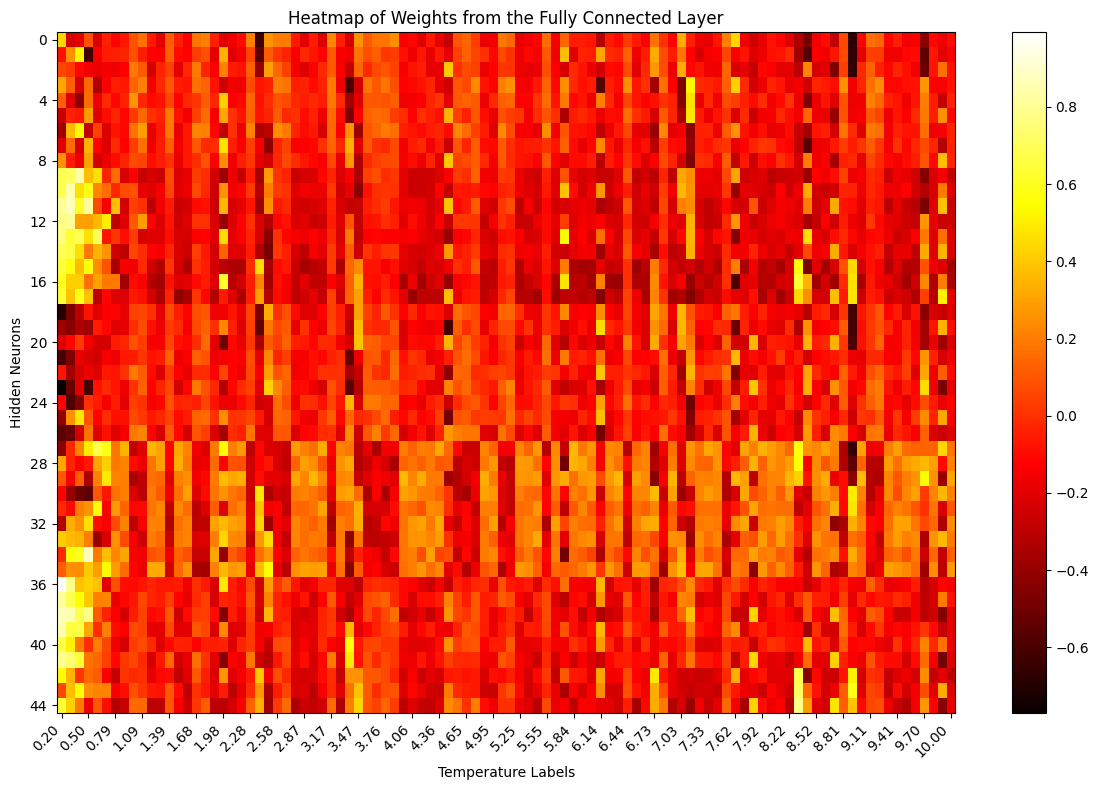

In [9]:
detect_phase_transition(weights, Beta)

In [14]:
def accumated_weights(weights,Beta):
    plt.figure(figsize=(12, 8))
    plt.title("Accumulated Weights vs Beta")
    plt.plot(Beta, np.sum(weights, axis=1), marker='o')

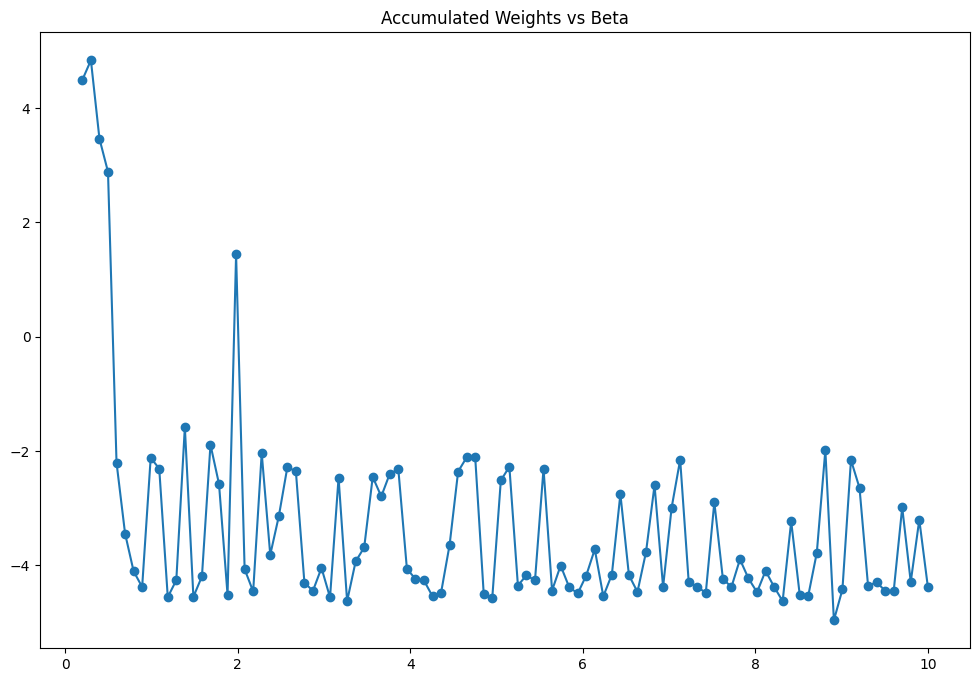

In [15]:
accumated_weights(weights,Beta)